# 3.Application module

In this notebook, we demonstrate how to train survival models using HiST application module based on spatial gene profiles predicted by HiST prediction module.

xx refers to the directory created by the function based on the date

## Import

In [ ]:
import os
import sys
import glob
sys.path.append('../src/')
import pickle
import numpy as np
import pandas as pd
import PIL.Image as Image
from datetime import date
from util.predict import *
from util.cluster import *
from util.survival_plot import *
from util.seed import seed_torch
from util.patch import reconstruct
from ApplicationModule.solver import TCGA_Solver
from FeatureExtraction.feature import extract_features, load_features


seed = 42
seed_torch(seed)
Image.MAX_IMAGE_PIXELS = 100000000000

## Preprocess clinical data

In [ ]:
# clinical data from TCGA
clinical = pd.read_csv('../data/TCGA/clinical/clinical_data.csv')
HE_path = '../output/TCGA/HE/'
HE_paths = glob.glob(os.path.join(HE_path,'*.jpg'))
HE_ids = [img.split('/')[-1].split('.')[0] for img in HE_paths]
HE_info = pd.DataFrame({'sample':HE_ids, 'file_path':HE_paths})
HE_info['bcr_patient_barcode'] = [string[0:12] for string in HE_info['sample']]
HE_info['tumor_type'] = [string[13:] for string in HE_info['sample']]
HE_info = HE_info[HE_info['tumor_type']=='01']
sample_info = clinical.merge(HE_info,on = 'bcr_patient_barcode')
sample_info_filtered = sample_info.drop_duplicates(subset='bcr_patient_barcode',keep='first')
sample_info_filtered = sample_info_filtered.reset_index(drop=True)
#filter by histological_type
drop_idx = sample_info_filtered.loc[sample_info_filtered['histological_type'] == '[Discrepancy]']['ajcc_pathologic_tumor_stage'].index
sample_info_filtered = sample_info_filtered.drop(drop_idx).reset_index(drop=True)
drop_idx = sample_info_filtered.loc[sample_info_filtered['histological_type'] == '[Not Available]']['ajcc_pathologic_tumor_stage'].index
sample_info_filtered = sample_info_filtered.drop(drop_idx).reset_index(drop=True)
input_df = sample_info_filtered[['sample','OS','OS.time','age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage']]
#drop NA
drop_idx = input_df[input_df.isna().any(axis=1) | input_df.isnull().any(axis=1)].index
input_df = input_df.drop(drop_idx).reset_index(drop=True)
#set stage by I,II,III,IV
input_df['ajcc_pathologic_tumor_stage'] = input_df['ajcc_pathologic_tumor_stage'].str.replace(r'([IV]+[ABC]*)$', lambda x: x.group(1).rstrip('ABC'), regex=True)
input_df = pd.get_dummies(input_df, columns=['gender'],drop_first=True,dtype = int)
#filter by ajcc_pathologic_tumor_stage
drop_idx = input_df.loc[input_df['ajcc_pathologic_tumor_stage'] == '[Discrepancy]']['ajcc_pathologic_tumor_stage'].index
input_df = input_df.drop(drop_idx).reset_index(drop=True)
drop_idx = input_df.loc[input_df['ajcc_pathologic_tumor_stage'] == '[Not Available]']['ajcc_pathologic_tumor_stage'].index
input_df = input_df.drop(drop_idx).reset_index(drop=True)

input_df['ajcc_pathologic_tumor_stage'].value_counts()

ajcc_pathologic_tumor_stage
Stage II     172
Stage III    125
Stage I       73
Stage IV      64
Name: count, dtype: int64

In [ ]:
input_df = pd.get_dummies(input_df, columns=['ajcc_pathologic_tumor_stage'],dtype = int)
sample_HEpath = pd.merge(input_df,sample_info_filtered,on = 'sample')[['sample','file_path']]
sample_HEpath_dict = sample_HEpath.set_index('sample')['file_path'].to_dict()
input_df['OS'].value_counts()

OS
0.0    342
1.0     92
Name: count, dtype: int64

In [ ]:
sample_list = list(input_df['sample'])
gene_list = list(pd.read_csv('../resource/CRC_SVG346_list.txt',header=None).iloc[:,0])
input_df

,sample,OS,OS.time,age_at_initial_pathologic_diagnosis,gender_MALE,ajcc_pathologic_tumor_stage_Stage I,ajcc_pathologic_tumor_stage_Stage II,ajcc_pathologic_tumor_stage_Stage III,ajcc_pathologic_tumor_stage_Stage IV
0,TCGA-3L-AA1B-01,0.0,475.0,61.0,0,1,0,0,0
1,TCGA-4N-A93T-01,0.0,146.0,67.0,1,0,0,1,0
2,TCGA-4T-AA8H-01,0.0,385.0,42.0,0,0,1,0,0
3,TCGA-5M-AAT4-01,1.0,49.0,74.0,1,0,0,0,1
4,TCGA-5M-AAT6-01,1.0,290.0,40.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
429,TCGA-QG-A5Z2-01,0.0,952.0,61.0,1,1,0,0,0
430,TCGA-QL-A97D-01,0.0,666.0,84.0,0,1,0,0,0
431,TCGA-SS-A7HO-01,0.0,1829.0,44.0,0,0,1,0,0
432,TCGA-T9-A92H-01,0.0,362.0,82.0,1,0,1,0,0


## Feature extraction

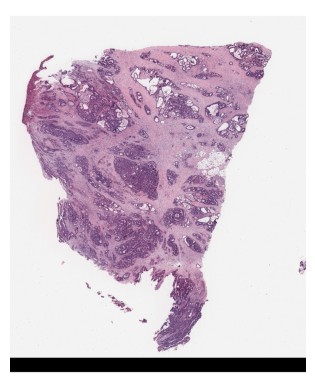

In [ ]:
reconstruct('../output/TCGA/tiles/TCGA-A6-A567-01/')

In [ ]:
# extract features for all tiles
TCGA_sample_features = extract_features(
                            tile_path = '../output/TCGA/tiles/',
                            img_ids = sample_list,
                            model_weight_path = '../resource/ctranspath.pth',
                            save = True,
                            seed = seed,
                            file = '../output/features/TCGA_sample_features.pkl')

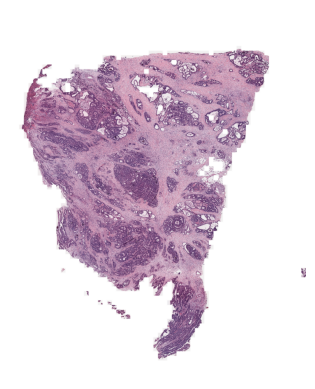

In [ ]:
reconstruct('../output/TCGA/clean_tiles_75/TCGA-A6-A567-01/')

In [ ]:
# extract features for clean tiles
TCGA_clean_features = extract_features(
                            tile_path = '../output/TCGA/clean_tiles_75/',
                            img_ids = sample_list,
                            model_weight_path = '../resource/ctranspath.pth',
                            save = True,
                            seed = seed,
                            file = '../output/features/TCGA_clean_features.pkl')

In [ ]:
## Load features
# TCGA_sample_features = load_features('../output/features/TCGA_sample_features.pkl')
# TCGA_clean_features = load_features('../output/features/TCGA_clean_features.pkl')

## Predict tumor and spatial gene by HiST prediction module

##### Visualize for single sample

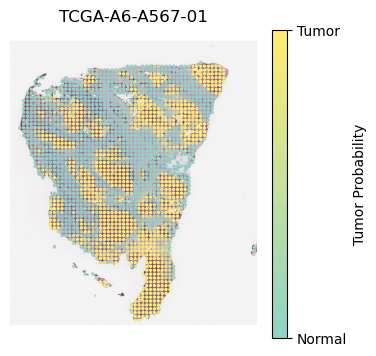

In [ ]:
sample2show = "TCGA-A6-A567-01"
VisualizeTumorHE(
    sample_id=sample2show,
    sample_list=sample_list,
    features=TCGA_clean_features,
    sample_HEpath_dict=sample_HEpath_dict,
    model_path='../output/model/tumor/checkpoint_all/xx/200_model.pth',
    clean_tile_dir="../output/TCGA/clean_tiles_75", # None if not available
    alpha=1,
    colors=["#8dd3c7","#ffed6f"],
    label = False,
    out_dir = None
)

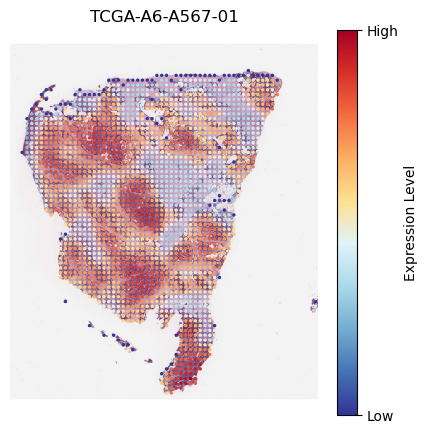

In [ ]:
sample2show = "TCGA-A6-A567-01"
gene2show = 'ACTB'
VisualizeGeneHE(
    sample_id=sample2show,
    gene=gene2show,
    sample_list=sample_list,
    gene_list=gene_list,
    features=TCGA_clean_features,
    sample_HEpath_dict=sample_HEpath_dict,
    model_path='../output/model/gene/checkpoint_all/xx/200_model.pth',
    clean_tile_dir="../output/TCGA/clean_tiles_75/", # None if not available
    alpha=1,
    out_dir=None
)

##### Get prediction for all samples

In [ ]:
predict_gene_matrix_list = GetPredictGMList(
    sample_list=sample_list,
    gene_list=gene_list,
    all_sample_features=TCGA_sample_features,
    model_path='../output/model/tumor/checkpoint_all/xx/200_model.pth',
    seed=seed
)

In [ ]:
predict_mask_matrix_list = GetPredictTMList(
    sample_list=sample_list,
    all_sample_features=TCGA_sample_features,
    model_path='../output/model/gene/checkpoint_all/xx/200_model.pth',
    seed=seed
)

In [ ]:
# save results
os.makedirs('../output/predict_matrix/',exist_ok=True)
with open('../output/predict_matrix/predict_gene_matrix_list.pkl','wb') as f:
    pickle.dump(predict_gene_matrix_list,f)
with open('../output/predict_matrix/predict_mask_matrix_list.pkl','wb') as f:
    pickle.dump(predict_mask_matrix_list,f)

## Train survival model

In [ ]:
TCGAsolver = TCGA_Solver(
    seed = 1,
    num_classes=1,
    drop_path_rate=0.4,
    depths=[2, 2, 2, 2],
    dims=[3, 4, 5, 6],
    clinical_col=6,
    loss = 'coxph',
    epochs = 200,
    lr = 0.015,
    kfold_seed = 15,
    verbose = False
)
TCGAsolver.train_kfold(
    input_df=input_df,
    gene_matrix_list=predict_gene_matrix_list,
    mask_matrix_list=predict_mask_matrix_list,
    he_features=TCGA_sample_features,
    method='gene', # only use gene features
    kfold_splits=5,
    out_dir='../output/model/TCGA/checkpoint_5fold/',
)

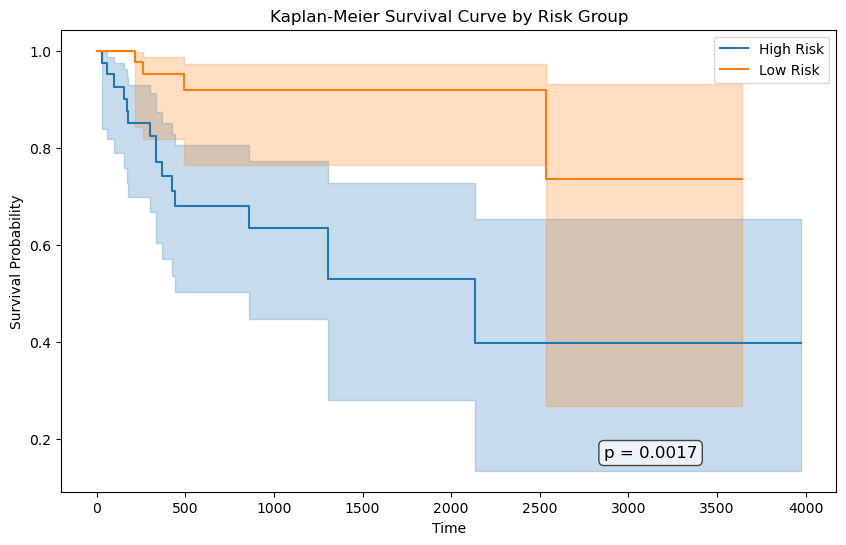

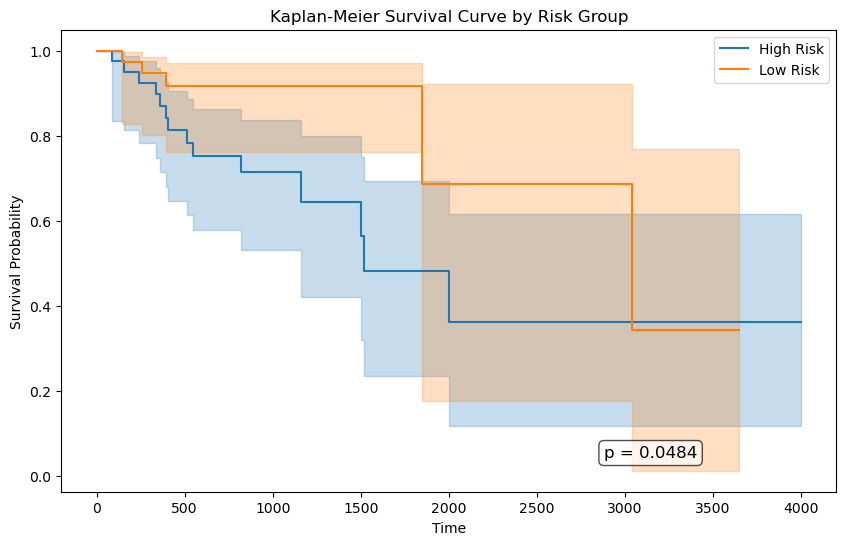

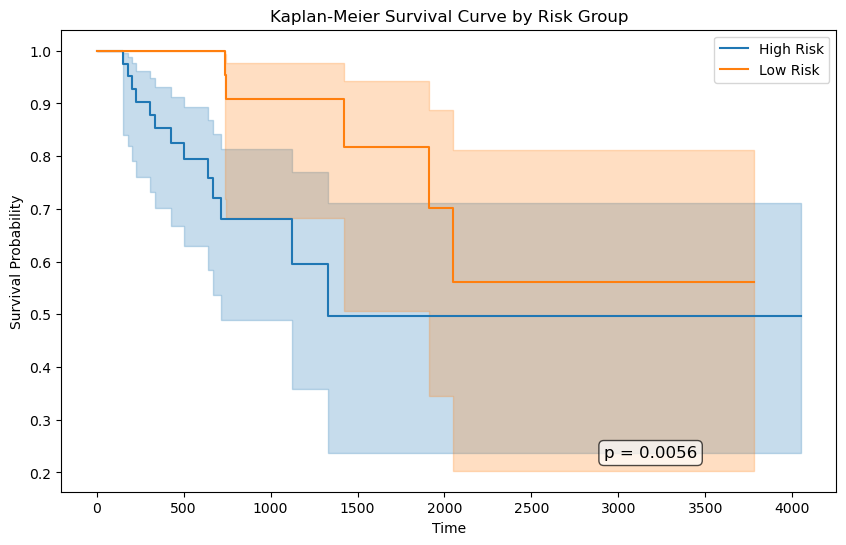

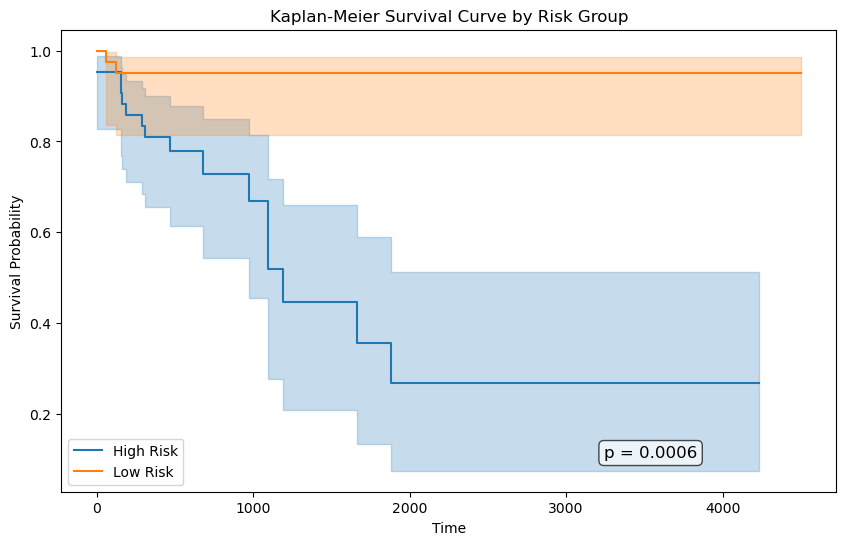

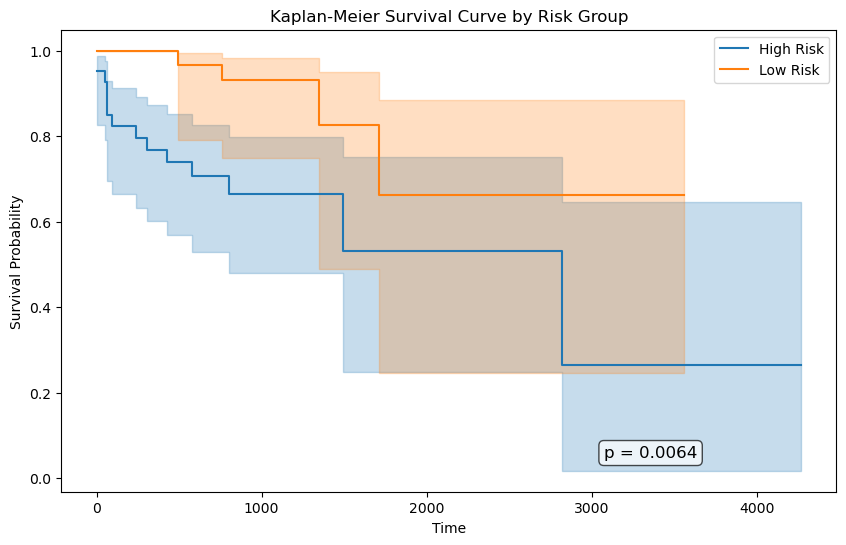

In [ ]:
# plot survival curve
plot_km('../output/model/TCGA/checkpoint_5fold/xx',k = 5)